# Regression homework in week 8
- 2019.11.6
- 苏锦华 2017201620
## Requirements
- regression sells(y) on sessions(x1) and CTR(x2), draw error figure and judge sequence-autocorrelation by DW test
- use iteration method for data processing to alleviate sequence-autocorrelation
- use first order difference
- compare the property of above three regression
## Subgoal
- practise matrix manipulation using numpy
- don't use package. do it from basic frame
- wrap a class for multiple linear regression and method for data processing
- practise vim for text editing

In [41]:
import numpy as np
import matplotlib.pyplot as plt

In [49]:
file.head()

,周次,销售额y,每周演出场次x1,周点击率x2
0,1,893.93,5,292
1,2,1091.27,5,252
2,3,1229.97,5,267
3,4,1045.85,5,379
4,5,997.24,5,318


In [42]:
import pandas as pd
file = pd.read_excel('huigui.data.xlsx')
X = file.iloc[:,2:].to_numpy()
y = file.iloc[:,1].to_numpy()

In [200]:
class multiple_linear_regression(object):
    def __init__(self,y,X,*args):
        self.y = y
        self.X = X 
        self.name = args
        self.total_dict = {}
        self.OLS()
        self.iteration_method()
        self.first_order_difference()
    def regression(self,y,X):
        Beta = np.linalg.inv(((X-X.mean(axis = 0)).T.dot(X-X.mean(axis = 0)))).dot((X-X.mean(axis = 0)).T.dot((y - y.mean())))
        const = y.mean() - np.sum(X.mean(axis = 0)*Beta) 
        return {'cons':const,'coef':Beta}
    def pretty_report(self,type = 'OLS'):
        def get_regression_result(cons,coef,name):
            s = name[0] + ' = ' + str(cons)
#             print(ceof)
            for i in range(len(coef)):
                s += ' + ' + str(coef[i]) +'*'+ name[i+1] + '_' + str(i+1)
            return s
        template = \
"""
method: {type}
-------------------
{result}
DW_value: {DW}
rho: {rho}
error figure on each explanatory varible:
"""
        if type == 'OLS':
            name = self.name
        elif type == 'iteration_method':
            name = ['[{0}(t) - rho * {0}(t-1)]'.format(s) for s in self.name]     
        elif type == 'first_order_difference':
            name = ['delta_'+s for s in self.name]
#         para_dict = {}
#         print()
#         print(para_dict)
        para_dict = self.total_dict[type]
        format_dict = {'type':type,'result':get_regression_result(para_dict['cons'],para_dict['coef'],name),\
                      'DW':para_dict['DW'],'rho':para_dict['rho']}
        print(template.format(**format_dict))
        self.error_figure(type)
    def DW_test(self,type = 'OLS'):
        para_dict = self.total_dict[type]
        X,y,coef,cons = para_dict['X'],para_dict['y'],para_dict['coef'],para_dict['cons']
#         print(coef)
#         print(cons)
        error = X.dot(coef) + cons - y
        DW = np.sum(np.diff(error)**2) / np.sum(error[1:]**2)
        return {'error':error,'DW':DW,'rho': 1 - 0.5 * DW}
    def error_figure(self,type = 'OLS'):
        X,error = self.total_dict[type]['X'],self.total_dict[type]['error']
        for i in range(X.shape[1]):
                plt.figure()
                plt.scatter(X[:,i],error)
                plt.show()
    def OLS(self):
        self.total_dict['OLS'] = self.regression(self.y,self.X)
        self.total_dict['OLS'].update({'X':self.X,'y':self.y})
        self.total_dict['OLS'].update(self.DW_test('OLS'))
    def iteration_method(self):
        rho = self.total_dict['OLS']['rho']
        y,X = self.y[1:] - rho*self.y[:-1],self.X[1:,:] - rho*self.X[:-1,:]
        self.total_dict['iteration_method'] = {'y':y,'X':X}
        self.total_dict['iteration_method'].update(self.regression(y,X))
        self.total_dict['iteration_method'].update(self.DW_test('iteration_method'))
    def first_order_difference(self):
        y_diff = np.diff(self.y) 
        X_diff = np.diff(self.X,axis = 0)
        self.total_dict['first_order_difference'] = {'y':y_diff,'X':X_diff}
        self.total_dict['first_order_difference'].update(self.regression(y_diff,X_diff))
        self.total_dict['first_order_difference'].update(self.DW_test('first_order_difference'))


method: OLS
-------------------
Sell = -574.0623902058405 + 191.09849049375447*Session_1 + 2.045137363395262*CTR_2
DW_value: 0.7462663045239724
rho: 0.6268668477380138
error figure on each explanatory varible:



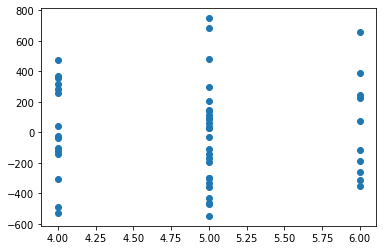

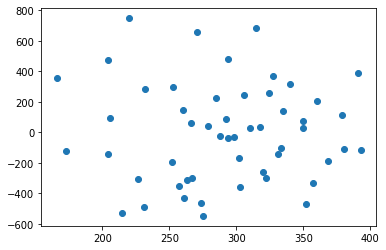


method: iteration_method
-------------------
[Sell(t) - rho * Sell(t-1)] = -179.1101542379743 + 211.10636358443725*[Session(t) - rho * Session(t-1)]_1 + 1.436719729442393*[CTR(t) - rho * CTR(t-1)]_2
DW_value: 1.7410737579984774
rho: 0.1294631210007613
error figure on each explanatory varible:



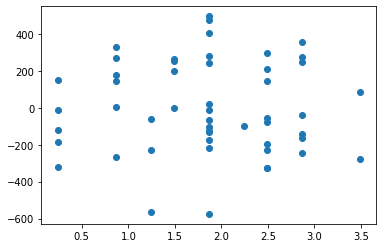

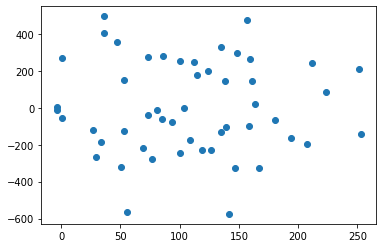


method: first_order_difference
-------------------
delta_Sell = 7.698100775695237 + 209.89105753737442*delta_Session_1 + 1.3989770599380433*delta_CTR_2
DW_value: 2.0740966286253477
rho: -0.03704831431267386
error figure on each explanatory varible:



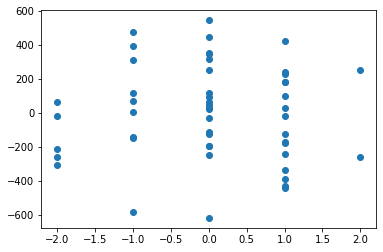

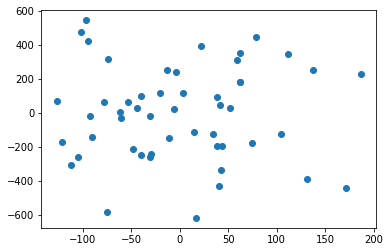

In [202]:
mlr = multiple_linear_regression(y,X,'Sell','Session','CTR')
for t in ['OLS','iteration_method','first_order_difference']:
    mlr.pretty_report(t)

## Conclusion
Simply using OLS on the sequence data for regression has a risk of autocorrelation.
- In error figure, we can see that error increases as first explanatory variable increases, which indicate that the consumption of indepence of each error may not be correct.
- With DW-test, positive autocorrelation can not be ignored and the estimate of rho reaches 0.6.
- By checking DW-test table, in context the uper is 1.462 while the lower is 1.628, so the null hypothesis can be denied with confidence of 95%. That indicates real autocorrelation.
- By two method of data processing, the new regression results all pass DW-test.
- In this case, even the rho is just 0.6, a bit far from 1, theoratically first_order_difference may be worse than iteration method.
- Since I only iter one times with iteration method for it has erasered the autocorrelation, first_order_difference performed better than iteration method.